In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Layer

In [2]:
def load_images(folder_path, image_size=(64,64)):
    data = []
    labels = []

    label = os.path.basename(folder_path)  # Extract the label from the folder name

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):  # Check if it is a file
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image was read correctly
                img = cv2.resize(img, image_size)  # Resize images to a common size
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels)

dataset_path = r"E:\Dataset\Chest CT Scan Images\Augmented_Images_1000"

# Load images for each type of chest X-ray
data_Adenocarcinoma, labels_Adenocarcinoma = load_images(os.path.join(dataset_path, 'Adenocarcinoma'))
data_Large_cell_carcinoma, labels_Large_cell_carcinoma = load_images(os.path.join(dataset_path, 'Large cell carcinoma'))
data_Normal, labels_Normal = load_images(os.path.join(dataset_path, 'Normal'))
data_Squamous_cell_carcinoma, labels_Squamous_cell_carcinoma = load_images(os.path.join(dataset_path, 'Squamous cell carcinoma'))

In [3]:
data_Adenocarcinoma.shape

(1000, 64, 64, 3)

In [4]:
# Combine data and labels for all tumor types
All_data = np.concatenate([data_Adenocarcinoma, data_Large_cell_carcinoma, data_Normal,data_Squamous_cell_carcinoma])
All_labels = np.concatenate([labels_Adenocarcinoma, labels_Large_cell_carcinoma, labels_Normal, labels_Squamous_cell_carcinoma])

In [5]:
All_data.shape

(4000, 64, 64, 3)

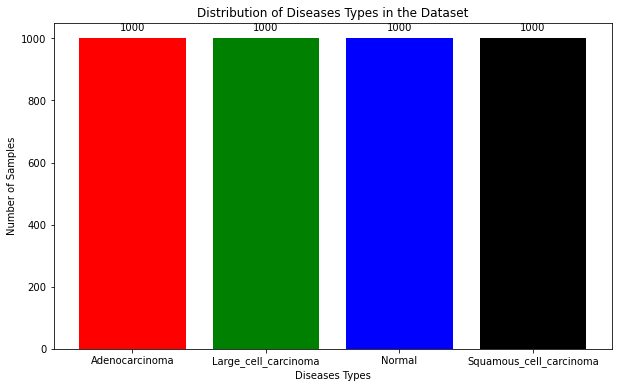

In [6]:
unique_labels, label_counts = np.unique(All_labels, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts, color=['red', 'green', 'blue', 'black'])
plt.xlabel('Diseases Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Diseases Types in the Dataset')
for i, count in enumerate(label_counts):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')

plt.xticks(unique_labels, ['Adenocarcinoma', 'Large_cell_carcinoma', 'Normal', 'Squamous_cell_carcinoma'])
plt.show()

In [7]:
# Normalize Pixel Values
All_data_normalized = All_data / 255.0

In [8]:
# Encode Labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(All_labels)
train_data, test_data, train_labels, test_labels = train_test_split(
    All_data_normalized, all_labels_encoded, test_size=0.15, random_state=42
)

In [9]:
train_data.shape

(3400, 64, 64, 3)

In [10]:
test_data.shape

(600, 64, 64, 3)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.tensordot(x, self.W, axes=(2, 0)) + self.b)
        at = tf.nn.softmax(et, axis=1)
        ot = x * at
        return tf.reduce_sum(ot, axis=1)

In [12]:
image_size = (64, 64)
num_classes = 4

In [13]:
from tensorflow.keras.models import Model
inputs = Input(shape=(image_size + (3,)))

# CNN layers with Dropout
x = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)  
x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x) 
x = Flatten()(x)

x = Reshape((1, -1))(x)

lstm_out = LSTM(50, return_sequences=True)(x)
lstm_out = Dropout(0.4)(lstm_out) 

attention_output = Attention()(lstm_out)

combined_output = Add()([attention_output, tf.reduce_sum(lstm_out, axis=1)])

outputs = Dense(num_classes, activation="softmax")(combined_output)

combined_model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=0.001)
combined_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stopping_callback = EarlyStopping(patience=6, monitor="val_loss", mode="min", restore_best_weights=True)

combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 16)           448       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 31, 31, 16)           0         ['max_pooling2d[0][0]']   

In [14]:
# Train the model with callbacks
history = combined_model.fit(
    train_data,
    train_labels,
    epochs=40,
    batch_size=16,
    validation_split=0.15,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/40
181/181 [==============================] - ETA: 0s - loss: 0.9973 - accuracy: 0.5471

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


181/181 [==============================] - 26s 83ms/step - loss: 0.9973 - accuracy: 0.5471 - val_loss: 1.1631 - val_accuracy: 0.5137
Epoch 2/40
181/181 [==============================] - 13s 71ms/step - loss: 0.6210 - accuracy: 0.7478 - val_loss: 0.5123 - val_accuracy: 0.7902
Epoch 3/40
181/181 [==============================] - 13s 72ms/step - loss: 0.4462 - accuracy: 0.8204 - val_loss: 0.4106 - val_accuracy: 0.8255
Epoch 4/40
181/181 [==============================] - 13s 72ms/step - loss: 0.3843 - accuracy: 0.8460 - val_loss: 0.3933 - val_accuracy: 0.8471
Epoch 5/40
181/181 [==============================] - 13s 72ms/step - loss: 0.3320 - accuracy: 0.8696 - val_loss: 0.3140 - val_accuracy: 0.8745
Epoch 6/40
181/181 [==============================] - 13s 72ms/step - loss: 0.2602 - accuracy: 0.9003 - val_loss: 0.2830 - val_accuracy: 0.8922
Epoch 7/40
181/181 [==============================] - 13s 70ms/step - loss: 0.2288 - accuracy: 0.9152 - val_loss: 0.3537 - val_accuracy: 0.8549
Epo

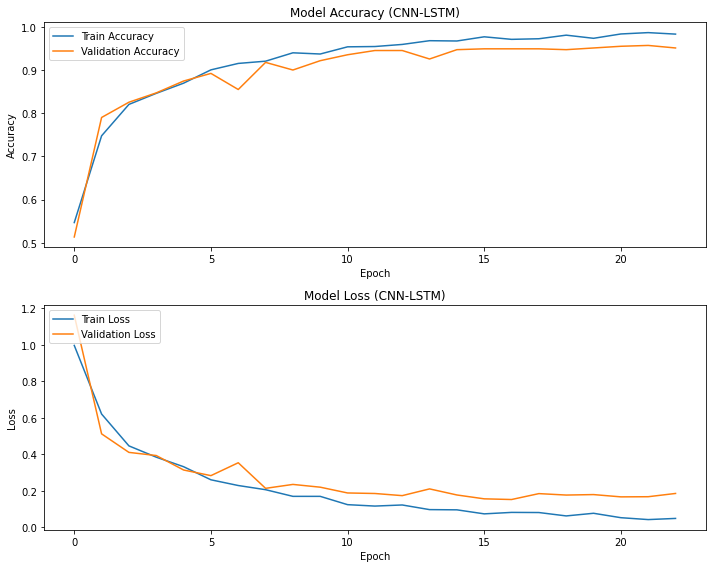

In [15]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy (CNN-LSTM)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss (CNN-LSTM)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
#combined_model.save("trained_combined_model_Attention.h5")